# NYCU Machine Learning 2024 : HW4 SVM

In [735]:
import numpy as np
import cvxpy as cp
import pandas as pd

from pathlib import Path
from rich import print
from dataclasses import dataclass, field
from typing import Callable
import matplotlib.pyplot as plt

In [736]:
np.set_printoptions(precision=4)

In [737]:
LABEL = ["Setosa" , "Versicolor" , "Virginica" ]

COLOR_1 = dict(zip(LABEL, ["red" , "green" , "blue"]))
COLOR_2 = dict(zip(LABEL, ["pink" , "yellow" , "orange"]))
COLOR_3 = dict(zip(LABEL, ["brown", "lightgreen", "navy", "magenta"]))
COLOR_4 = dict(zip(LABEL, ["teal", "gold", "violet", "coral"]))

COLOR_SELECT = {
    "before": {
        "train":COLOR_1,
        "test":COLOR_2,
    },
    "after": {
        "train":COLOR_3,
        "test":COLOR_4,
    }
}

COLUMN_NAME = ["Sepal length", "Sepal width" , "Petal length" , "Petal width" , "Label"]
TRAIN_DATA_SIZE = 25
ASSETS = "./assets"

In [738]:
assets_folder = Path(ASSETS)
assets_folder.mkdir(parents=True, exist_ok=True) 

In [739]:
def load_iris_file(with_name:bool=False)->pd.DataFrame:
    df = pd.read_fwf("./iris.txt")
    
    df_new = pd.DataFrame({k:[v] for k ,v in zip(COLUMN_NAME , df.columns)},dtype=float)
    df.columns = COLUMN_NAME
    df_new = pd.concat([df_new, df], axis=0).reset_index().drop(columns=["index"])
    
    if not with_name:
        return df_new
    
    df_with_name = df_new.copy()
    
    df_with_name["Label"] = df_with_name["Label"].apply(lambda x : LABEL[int(x)-1])
    
    return df_with_name

In [740]:
df = load_iris_file(with_name=True)
df

,Sepal length,Sepal width,Petal length,Petal width,Label
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


In [741]:
POSITIVE_CLASS ,NEGATIVE_CLASS= "Versicolor" , "Virginica"

In [742]:
df_need = df[["Petal length","Petal width", "Label"]]
df_need

,Petal length,Petal width,Label
0,1.4,0.2,Setosa
1,1.4,0.2,Setosa
2,1.3,0.2,Setosa
3,1.5,0.2,Setosa
4,1.4,0.2,Setosa
...,...,...,...
145,5.2,2.3,Virginica
146,5.0,1.9,Virginica
147,5.2,2.0,Virginica
148,5.4,2.3,Virginica


In [743]:
df_need_pos = df_need[df_need["Label"] == POSITIVE_CLASS]
df_need_pos_train , df_need_pos_test = df_need_pos[:TRAIN_DATA_SIZE], df_need_pos[TRAIN_DATA_SIZE:]

In [744]:
df_need_neg = df_need[df_need["Label"] == NEGATIVE_CLASS]
df_need_neg_train , df_need_neg_test = df_need_neg[:TRAIN_DATA_SIZE], df_need_neg[TRAIN_DATA_SIZE:]

In [745]:
df_need_train = pd.concat([df_need_pos_train, df_need_neg_train]).reset_index().drop(columns=["index"])
df_need_test  = pd.concat([df_need_pos_test, df_need_neg_test]).reset_index().drop(columns=["index"])

In [746]:
label_to_index = {POSITIVE_CLASS : 1 , NEGATIVE_CLASS : -1}
index_to_label = {1 : POSITIVE_CLASS , -1 : NEGATIVE_CLASS}


label_to_index_np = np.vectorize(label_to_index.get)
index_to_label_np = np.vectorize(index_to_label.get)

## Model

In [747]:

def rbf(sigma: float) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    def run(x_1: np.ndarray, x_2: np.ndarray) -> np.ndarray:
        # 检查维度是否匹配
        assert x_1.shape[0] == x_2.shape[0], "输入的两个向量必须有相同的特征数"

        # upper = np.square(np.linalg.norm(x_1-x_2 , axis=0))
        
        # return np.exp(-upper / (2 * sigma ** 2))
        
        # 计算欧氏距离的平方
        distance_squared = np.sum((x_1 - x_2) ** 2, axis=0)
        
        # 计算 RBF 核函数值
        kernel_value = np.exp(-distance_squared / (2 * sigma ** 2))
        
        if x_2.ndim != 1 and x_2.shape[1] == 1:
            kernel_value = kernel_value.reshape(-1,1)
            
        
        return kernel_value

    return run

def poly(p:int)-> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    def run(x_1:np.ndarray, x_2:np.ndarray)->np.ndarray:
        assert x_1.shape[0] == x_2.shape[0], "输入的两个向量必须有相同的特征数"
        
        return (x_1.T @ x_2)**p
    
    return run

def linear() -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    
    def run(x_1:np.ndarray, x_2:np.ndarray)->np.ndarray:
        assert x_1.shape[0] == x_2.shape[0], "输入的两个向量必须有相同的特征数"
        
        return x_1.T @ x_2
    
    return run

class Kernel:
    kernel_dict = {
        "linear":linear,
        "rbf": rbf,
        "poly": poly,
    }
        
    @staticmethod
    def get_kernel(name:str, config:dict) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
        if name not in Kernel.kernel_dict:
            raise NotImplementedError(f"{name} kernel not implemented. Available kernels: {list(Kernel.kernel_dict.keys())}")
        
        func = Kernel.kernel_dict[name]
        
        return func(**config) 

In [753]:
class SupportVectorMachine:
    def __init__(self, C:int, kernel_name:str="linear", kernel_arg:dict=dict(),threshold:float=1e-20):
        self._c = C
        self._threshold = threshold
        # like ("ay": ... , "x": ...,)
        self._a_y_x :np.ndarray = None
        self._b :float = None
        self._kernel  = Kernel.get_kernel(kernel_name, kernel_arg)
        self._kernel_info = {"name":kernel_name, "arg": kernel_arg}
        return
    
    @property
    def alpha(self)->np.ndarray:
        return self._a_y_x[:, 0].reshape(-1,1)
    
    @property
    def bias(self)->np.ndarray:
        return self._b
    
    def _build_k_matrix(self, x:np.ndarray)->np.ndarray:
        size = x.shape[0]
        return np.array([[self._kernel(x[i], x[j]) for j in range(size)] for i in range(size)])
    
    def _find_alpha(self, K:np.ndarray, x:np.ndarray , y:np.ndarray)-> tuple[np.ndarray,np.ndarray]:
        size = x.shape[0] 
        alpha = cp.Variable(size)
        
        big_k = np.outer(y,y) * K  
        big_k = cp.psd_wrap(big_k)
        
        objective = cp.Minimize((1/2) * cp.quad_form(alpha, big_k) -cp.sum(alpha))
        constraints = [
            cp.sum(cp.multiply(alpha, y)) == 0,  
            alpha >= 0, 
            alpha <= self._c
        ]
        problem = cp.Problem(objective, constraints) 
        problem.solve(solver=cp.CLARABEL) # verbose=True
        alpha = alpha.value
        
        # filter the important one 
        support_vectors = np.where((self._c >= alpha)& (alpha > self._threshold) )[0]
        return alpha , support_vectors
    
    def _find_bias(self,alpha:np.ndarray,support_vectors:np.ndarray, y: np.ndarray, K: np.ndarray):
        K_hat = K[support_vectors][:, support_vectors]
        alpha_hat = alpha[support_vectors]
        y_hat = y[support_vectors]
        
        res = y_hat - K_hat @ (alpha_hat * y_hat)
        
        return np.mean(res)
    
    def train(self, x:np.ndarray, y:np.ndarray): # [batch, feature]   [batch, 1]
        # get the a
        K = self._build_k_matrix(x) 
        # print(K)
        alpha , support_vector = self._find_alpha(K,x,y)
        # find the best b
        self._b = self._find_bias(alpha,support_vector,y,K)
        
        alpha , y = alpha.reshape(-1,1), y.reshape(-1,1)
        
        table = np.hstack((alpha , y, x))
        
        self._a_y_x = table[support_vector]
        
        return 
    
    def cal_one_item(self, ay:np.ndarray, x_kernel:np.ndarray, x_item: np.ndarray)->np.ndarray:
        # x [1, feature]
        # x_kernel [a, feature]
        
        res = np.sum(ay * self._kernel(x_kernel.T, x_item.reshape(-1,1))) + self._b
        
        return res
    
    def __call__(self, x : np.ndarray, with_sign:bool=False)->np.ndarray:
        # x [batch, feature]
        a, y, x_kernel = self._a_y_x[:, 0].reshape(-1,1) , self._a_y_x[:, 1].reshape(-1,1),  self._a_y_x[:, 2:]
        
        result = [self.cal_one_item(a*y, x_kernel=x_kernel, x_item=x_item) for x_item in x]
        res = np.hstack(result) 
        
        if with_sign:
            res = np.sign(res)
        
        return res
    
    def acc(self, x: np.ndarray,y: np.ndarray)->tuple[float, np.ndarray]:
        
        y_hat = self.__call__(x, True)
        
        return np.mean(y_hat == y) , y_hat
    
    @property
    def info(self):
        return {"kernel": self._kernel_info, "support vector num":self._a_y_x.shape[0] , "C" : self._c, "b":f"{self._b:.4f}"}
    
    def short_name(self):
        kernel_name = self._kernel_info['name']
        
        if len(self._kernel_info["arg"]) > 0:
            kernel_arg_name, kernel_arg = next(iter(self._kernel_info["arg"].items()))
            
        else :
            kernel_arg_name, kernel_arg = "", ""
        return f"{kernel_name}_{kernel_arg_name}_{kernel_arg}_C_{self._c}"
    
    def __str__(self):
        return str(self.info)
    
    def __repr__(self):
        return self.__str__()
    

In [754]:
model = SupportVectorMachine(C =10 , kernel_name="rbf", kernel_arg={"sigma":2} ) # , kernel_name="rbf",kernel_arg={"sigma" : 2}

In [755]:
@dataclass
class TestResult:
    model:SupportVectorMachine
    acc : float
    bias_ : str
    alpha : np.ndarray
    
    bias : float = field(repr=False)
    x_test : np.ndarray = field(repr=False)
    y_test : np.ndarray = field(repr=False)
    y_hat : np.ndarray = field(repr=False)
    
    @classmethod
    def build(cls, model:SupportVectorMachine, x:np.ndarray, y:np.ndarray):
        model = model
        acc, y_hat = model.acc(x=x,y=y)
        alpha = model.alpha.reshape(-1)
        bias = model.bias
        bias_ = f"{model.bias:.4f}"
        
        return cls(model, acc,bias_,alpha,bias, x,y,y_hat)
    
    def plot_decision_boundary(self,save_folder:Path=None, resolution=100, padding=1.0, with_contours=True):
        """
        绘制任何二维模型的决策边界。

        Parameters:
        - model: 训练好的模型，必须支持 `predict` 或类似接口 (可以传入自定义SVM模型)。
        - x: 训练数据，形状为 [num_samples, 2]。
        - y: 训练标签，形状为 [num_samples] 或 [num_samples, 1]。
        - resolution: 网格的分辨率，默认为 100。
        - padding: 数据边界填充距离，以保证决策边界的完整显示。
        - with_contours: 是否显示轮廓线，默认为 True。
        """
        # 设定网格范围
        x,y  = self.x_test, self.y_test
        x_min, x_max = x[:, 0].min() - padding, x[:, 0].max() + padding
        y_min, y_max = x[:, 1].min() - padding, x[:, 1].max() + padding
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution))
        grid_points = np.c_[xx.ravel(), yy.ravel()]

        # 在网格点上获取模型的预测值
        Z = self.model(grid_points, with_sign=True)
            
        Z = Z.reshape(xx.shape)

        # 绘制训练数据点和决策边界
        plt.scatter(x[:, 0], x[:, 1], c=y, cmap='bwr', s=50, edgecolors='k')
        plt.contourf(xx, yy, Z, alpha=0.3, cmap="bwr")
        
        if with_contours:
            plt.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=["--", "-", "--"], colors="k")
            
        # 添加图例和标签
        plt.xlabel("X1")
        plt.ylabel("X2")
        plt.title(f"Model decision boundary\nModel:{self.model}\nAcc:{self.acc*100:.2f}%")
        
        if save_folder is not None:
            filename = save_folder.joinpath(f"{self.model.short_name()}.png")
            plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)  

        plt.show()

In [756]:
def test_run(df_train:pd.DataFrame, df_test:pd.DataFrame, kernel_name:str , kernel_arg:dict=dict(), C_list:list[int] = [1,10,100]):
    
    if len(kernel_arg) != 0:
        kernel_item = next(iter(kernel_arg.items()))
        kernel_arg_name ,kernel_arg_value_list = kernel_item
        kernel_arg_list = [{kernel_arg_name: item} for item in kernel_arg_value_list]
    else:
        kernel_arg_list = [dict()]
    # return 
    train_x , train_y = df_train.drop(columns=["Label"]).to_numpy() , df_train["Label"].to_numpy() 
    test_x , test_y = df_test.drop(columns=["Label"]).to_numpy() , df_test["Label"].to_numpy() 
    
    train_y, test_y = label_to_index_np(train_y), label_to_index_np(test_y)
    
    model_list = []
    
    for kernel_arg_item in kernel_arg_list:
        for c in C_list:
            model = SupportVectorMachine(
                C=c,
                kernel_name=kernel_name,
                kernel_arg=kernel_arg_item
            )
            model.train(x=train_x, y=train_y)
            
            result = TestResult.build(model, x=test_x, y=test_y)
            
            model_list.append(result)
    
    
    return model_list

## Test Linear

In [757]:
model_linear = test_run(
    df_train=df_need_train,
    df_test=df_need_test,
    kernel_name="linear",
)

In [758]:
print(model_linear)

[
    TestResult(
        model={'kernel': {'name': 'linear', 'arg': {}}, 'support vector num': 50, 'C': 1, 'b': '10.6297'},
        acc=np.float64(0.96),
        bias_='10.6297',
        alpha=array([1.0000e+00, 6.6667e-02, 1.0000e+00, 4.8799e-11, 1.0000e+00,
       1.2896e-10, 1.0000e+00, 1.5628e-11, 1.8811e-10, 5.4316e-11,
       1.8377e-11, 1.6861e-10, 2.8067e-11, 1.0000e+00, 3.0077e-11,
       1.7918e-10, 6.6667e-02, 3.0760e-11, 6.6667e-02, 2.9700e-11,
       1.0000e+00, 4.8799e-11, 1.0000e+00, 1.3244e-10, 7.9069e-11,
       2.0787e-11, 1.0000e+00, 3.8922e-11, 3.6439e-10, 3.5208e-11,
       2.2945e-11, 1.0000e+00, 4.8671e-11, 1.2641e-10, 1.9752e-11,
       1.0000e+00, 2.0000e-01, 6.1862e-11, 1.0000e+00, 4.1763e-11,
       4.4378e-11, 1.8952e-09, 1.9391e-11, 1.5977e-11, 1.0000e+00,
       3.2088e-11, 1.0000e+00, 2.4262e-11, 1.0000e+00, 4.7702e-11])
    ),
    TestResult(
        model={'kernel': {'name': 'linear', 'arg': {}}, 'support vector num': 50, 'C': 10, 'b': '15.0764'},
        acc=np.float64(0.94),
        bias_='15.0764',
        alpha=array([3.0420e-10, 4.0754e-10, 9.0000e+00, 1.0620e-10, 5.3331e-10,
       1.5736e-10, 1.0000e+01, 4.5154e-11, 1.7293e-10, 1.2399e-10,
       5.0345e-11, 2.3911e-10, 6.4699e-11, 3.0420e-10, 8.0863e-11,
       1.9999e-10, 4.0754e-10, 6.8054e-11, 4.0754e-10, 7.0448e-11,
       1.0000e+01, 1.0620e-10, 9.0000e+00, 1.4142e-10, 1.3302e-10,
       5.6960e-11, 8.0000e+00, 1.0904e-10, 8.6025e-10, 9.4465e-11,
       7.5255e-11, 1.0000e+01, 1.8757e-10, 4.2013e-10, 5.5020e-11,
       3.2493e-10, 6.1979e-10, 1.4250e-10, 3.3266e-10, 9.4982e-11,
       1.0214e-10, 1.8259e-09, 6.2808e-11, 5.2305e-11, 1.0000e+01,
       8.3617e-11, 1.8418e-10, 8.4354e-11, 1.0000e+01, 1.2384e-10])
    ),
    TestResult(
        model={'kernel': {'name': 'linear', 'arg': {}}, 'support vector num': 50, 'C': 100, 'b': '11.2977'},
        acc=np.float64(0.92),
        bias_='11.2977',
        alpha=array([7.4693e-09, 2.5846e-04, 4.4444e+01, 5.2582e-09, 3.5908e-04,
       3.7132e-09, 1.0000e+02, 1.9094e-09, 3.4000e-09, 1.6088e-08,
       1.7549e-09, 1.3843e-04, 1.4438e-09, 7.4693e-09, 6.6283e-09,
       1.1058e-08, 2.5846e-04, 1.3895e-09, 2.5846e-04, 2.0356e-09,
       1.0000e+02, 5.2582e-09, 4.4444e+01, 1.9418e-09, 4.3305e-09,
       9.6661e-10, 7.1595e-09, 2.9218e-09, 1.3464e-04, 1.8799e-09,
       3.7969e-09, 1.0000e+02, 6.2639e-05, 1.0010e-04, 9.9210e-10,
       2.9510e-09, 9.6917e-09, 2.3996e-09, 2.6503e-09, 8.9698e-10,
       1.1639e-09, 1.6231e-04, 2.5546e-09, 1.9380e-09, 1.0000e+02,
       1.3512e-09, 2.4097e-09, 7.2161e-09, 8.8888e+01, 2.6646e-09])
    )
]

## Test RBF

In [759]:
model_rbf = test_run(
    df_train=df_need_train,
    df_test=df_need_test,
    kernel_name="rbf",
    kernel_arg={"sigma": [1,0.5,0.1, 0.05]}
)

In [760]:
print(model_rbf)

[
    TestResult(
        model={'kernel': {'name': 'rbf', 'arg': {'sigma': 1}}, 'support vector num': 49, 'C': 1, 'b': '-0.8077'},
        acc=np.float64(0.92),
        bias_='-0.8077',
        alpha=array([1.0000e+00, 1.4574e-01, 1.0000e+00, 1.8098e-09, 1.0000e+00,
       2.9873e-09, 1.0000e+00, 2.3853e-01, 4.2168e-09, 3.0246e-09,
       5.2797e-09, 6.3255e-09, 1.0268e-09, 1.0000e+00, 4.9296e-09,
       4.4038e-09, 1.4574e-01, 9.1194e-10, 1.4574e-01, 1.3294e-09,
       1.0000e+00, 1.8098e-09, 1.0000e+00, 3.2928e-09, 1.9648e-09,
       9.5769e-10, 1.0000e+00, 1.3198e-09, 1.8201e-08, 9.7464e-10,
       6.9926e-09, 7.8887e-09, 6.7668e-09, 1.1777e-09, 1.0000e+00,
       3.0217e-01, 1.6390e-09, 1.0000e+00, 1.2763e-09, 1.1367e-09,
       1.6935e-07, 9.9603e-09, 3.7359e-01, 1.0000e+00, 7.8134e-10,
       1.0000e+00, 1.8196e-08, 1.0000e+00, 1.3183e-09])
    ),
    TestResult(
        model={'kernel': {'name': 'rbf', 'arg': {'sigma': 1}}, 'support vector num': 50, 'C': 10, 'b': '-0.2601'},
        acc=np.float64(0.96),
        bias_='-0.2601',
        alpha=array([1.5639e-09, 1.0971e-09, 8.8908e+00, 1.0012e-09, 1.3275e-09,
       9.4984e-10, 1.0000e+01, 3.4598e-01, 1.0672e-09, 1.1960e-09,
       4.1520e-09, 8.6162e-10, 8.8174e-10, 1.5639e-09, 3.6895e-09,
       9.6721e-10, 1.0971e-09, 8.0344e-10, 1.0971e-09, 1.0321e-09,
       1.0000e+01, 1.0012e-09, 8.8908e+00, 1.0843e-09, 8.6266e-10,
       9.4682e-10, 8.1275e+00, 8.6788e-10, 1.3409e-09, 7.6468e-10,
       6.3880e-09, 1.0000e+01, 3.4365e-09, 1.3644e-09, 1.1102e-09,
       1.9551e-09, 1.1045e-09, 7.7834e-10, 5.4070e-09, 1.1579e-09,
       8.6583e-10, 1.6182e-09, 1.1140e-08, 8.8532e-08, 1.0000e+01,
       7.2005e-10, 8.3832e-05, 1.4382e-08, 1.0000e+01, 7.6460e-10])
    ),
    TestResult(
        model={'kernel': {'name': 'rbf', 'arg': {'sigma': 1}}, 'support vector num': 50, 'C': 100, 'b': '-1.2219'},
        acc=np.float64(0.94),
        bias_='-1.2219',
        alpha=array([1.4744e-08, 1.8075e-08, 4.4718e+01, 1.4001e-08, 1.9360e-08,
       9.0171e-09, 9.2222e+01, 8.6228e-07, 9.6603e-09, 2.9114e-08,
       3.3009e-08, 2.8241e-08, 7.7884e-09, 1.4744e-08, 6.0647e+00,
       1.1625e-08, 1.8075e-08, 6.9939e-09, 1.8075e-08, 1.0278e-08,
       1.0000e+02, 1.4001e-08, 4.4718e+01, 9.2531e-09, 9.2706e-09,
       4.4482e-09, 1.3349e-08, 4.2446e-09, 5.9532e-09, 4.3320e-09,
       5.1198e-09, 1.0000e+02, 4.3440e-09, 4.8957e-09, 4.5386e-09,
       1.0215e-08, 8.4002e-09, 5.3281e-09, 1.2862e-08, 5.9511e-09,
       5.5391e-09, 6.8374e-09, 5.7210e-09, 7.2348e-09, 1.0000e+02,
       4.4520e-09, 1.7411e-08, 5.4428e-09, 8.7723e+01, 4.6226e-09])
    ),
    TestResult(
        model={'kernel': {'name': 'rbf', 'arg': {'sigma': 0.5}}, 'support vector num': 50, 'C': 1, 'b': '-0.1943'},
        acc=np.float64(0.94),
        bias_='-0.1943',
        alpha=array([1.0876e-09, 1.4818e-09, 1.0000e+00, 1.4524e-09, 7.5844e-01,
       4.8575e-10, 1.0000e+00, 9.5985e-01, 5.1022e-10, 4.7193e-01,
       2.2075e-09, 3.4139e-07, 2.5735e-04, 1.0876e-09, 2.3737e-09,
       6.3395e-10, 1.4818e-09, 1.7628e-01, 1.4818e-09, 2.1391e-09,
       1.0000e+00, 1.4524e-09, 1.0000e+00, 6.4611e-10, 6.0490e-10,
       4.2541e-01, 8.9887e-01, 9.7839e-10, 4.0842e-09, 8.3329e-10,
       1.2721e-09, 1.0000e+00, 4.3605e-01, 1.2464e-08, 7.3083e-08,
       7.8233e-10, 9.3503e-10, 4.6445e-10, 1.7096e-09, 5.6851e-10,
       4.2758e-10, 3.9150e-09, 1.4965e-09, 6.0643e-01, 1.0000e+00,
       8.1233e-10, 1.0000e+00, 2.6848e-09, 1.0000e+00, 6.7226e-10])
    ),
    TestResult(
        model={'kernel': {'name': 'rbf', 'arg': {'sigma': 0.5}}, 'support vector num': 50, 'C': 10, 'b': 
'-0.3942'},
        acc=np.float64(0.96),
        bias_='-0.3942',
        alpha=array([6.4813e-10, 1.0597e-09, 5.9852e+00, 1.5268e-09, 1.0189e-09,
       4.3803e-10, 5.3969e+00, 1.0033e+00, 4.4533e-10, 2.5511e-08,
       6.9096e-09, 3.0060e+00, 1.6271e-09, 6.4813e-10, 1.1727e-08,
       6.4029e-10, 1.0597e-09, 1.1568e-09, 1.0597e-09, 1.6093e-09,
       1.0000e+01, 1.5268e

## Test poly

In [761]:
model_poly = test_run(
    df_train=df_need_train,
    df_test=df_need_test,
    kernel_name="poly",
    kernel_arg={"p":[2,3,4,5]}
)

In [762]:
print(model_poly)

[
    TestResult(
        model={'kernel': {'name': 'poly', 'arg': {'p': 2}}, 'support vector num': 50, 'C': 1, 'b': '12.0908'},
        acc=np.float64(0.9),
        bias_='12.0908',
        alpha=array([2.2797e-10, 2.2478e-10, 5.0000e-01, 7.6062e-11, 2.9913e-10,
       1.1683e-10, 1.0000e+00, 4.1397e-11, 1.3233e-10, 8.2171e-11,
       4.4247e-11, 1.3191e-10, 5.3789e-11, 2.2797e-10, 6.0221e-11,
       1.3280e-10, 2.2478e-10, 5.6073e-11, 2.2478e-10, 5.6876e-11,
       1.0000e+00, 7.6062e-11, 5.0000e-01, 1.1523e-10, 9.5308e-11,
       3.1092e-11, 3.3737e-10, 5.2088e-11, 1.4119e-10, 4.8700e-11,
       3.4341e-11, 1.0000e+00, 6.0702e-11, 1.0195e-10, 2.9656e-11,
       1.8413e-10, 1.8090e-10, 7.4220e-11, 2.4050e-10, 6.3795e-11,
       6.2723e-11, 1.7459e-10, 2.9708e-11, 2.4945e-11, 1.0000e+00,
       4.5771e-11, 3.4269e-10, 3.6371e-11, 1.0000e+00, 6.1243e-11])
    ),
    TestResult(
        model={'kernel': {'name': 'poly', 'arg': {'p': 2}}, 'support vector num': 50, 'C': 10, 'b': '14.7951'},
        acc=np.float64(0.9),
        bias_='14.7951',
        alpha=array([5.0887e-11, 2.3206e-11, 3.8295e+00, 1.6847e-11, 3.9587e-11,
       2.3075e-11, 9.4708e+00, 8.1377e-12, 3.0120e-11, 1.8613e-11,
       9.5377e-12, 1.5659e-11, 1.4113e-11, 5.0887e-11, 1.4755e-11,
       1.6997e-11, 2.3206e-11, 1.4416e-11, 2.3206e-11, 1.4798e-11,
       1.0000e+01, 1.6847e-11, 3.8295e+00, 3.2367e-11, 1.6802e-11,
       6.5652e-12, 3.4470e-11, 6.3598e-12, 3.7805e-12, 7.6320e-12,
       6.0229e-12, 1.0000e+01, 4.4466e-12, 2.0550e-12, 6.2729e-12,
       3.1446e-11, 1.6314e-11, 1.1263e-11, 4.2021e-11, 1.4882e-11,
       1.3887e-11, 6.2121e-12, 5.7703e-12, 4.6037e-12, 1.0000e+01,
       8.5786e-12, 5.4575e-11, 6.1906e-12, 7.1297e+00, 7.9782e-12])
    ),
    TestResult(
        model={'kernel': {'name': 'poly', 'arg': {'p': 2}}, 'support vector num': 50, 'C': 100, 'b': '14.2388'},
        acc=np.float64(0.9),
        bias_='14.2388',
        alpha=array([2.1760e-08, 1.8142e-08, 3.6910e+01, 6.1948e-09, 2.6386e-08,
       9.7732e-09, 9.3971e+01, 3.1405e-09, 1.2169e-08, 7.0796e-09,
       3.5269e-09, 1.0557e-08, 5.1951e-09, 2.1760e-08, 5.1819e-09,
       9.8462e-09, 1.8142e-08, 5.5491e-09, 1.8142e-08, 5.0461e-09,
       1.0000e+02, 6.1948e-09, 3.6910e+01, 1.3865e-08, 7.3598e-09,
       2.0063e-09, 4.3737e-08, 4.2020e-09, 1.8877e-08, 3.5903e-09,
       2.9085e-09, 1.0000e+02, 4.6682e-09, 1.0852e-08, 1.9931e-09,
       1.5621e-08, 2.2907e-08, 5.8083e-09, 1.8125e-08, 3.0110e-09,
       3.5565e-09, 2.6648e-08, 2.5167e-09, 2.0182e-09, 1.0000e+02,
       3.0183e-09, 2.0282e-08, 3.0103e-09, 6.7790e+01, 4.8858e-09])
    ),
    TestResult(
        model={'kernel': {'name': 'poly', 'arg': {'p': 3}}, 'support vector num': 50, 'C': 1, 'b': '10.6007'},
        acc=np.float64(0.9),
        bias_='10.6007',
        alpha=array([2.4761e-11, 1.0800e-11, 4.0473e-01, 6.2012e-12, 1.5274e-11,
       1.2283e-11, 8.7908e-01, 4.0755e-12, 1.5058e-11, 5.9440e-12,
       4.2959e-12, 6.3431e-12, 5.2035e-12, 2.4761e-11, 4.8022e-12,
       1.0635e-11, 1.0800e-11, 5.6960e-12, 1.0800e-11, 5.1150e-12,
       1.0000e+00, 6.2012e-12, 4.0473e-01, 1.5641e-11, 8.7647e-12,
       2.2429e-12, 1.4040e-11, 3.3383e-12, 1.2540e-12, 3.4888e-12,
       1.8142e-12, 1.0000e+00, 1.0252e-12, 1.1496e-12, 2.0907e-12,
       1.1906e-11, 7.8523e-12, 5.2568e-12, 1.5148e-11, 4.6198e-12,
       4.7778e-12, 1.1863e-12, 1.6700e-12, 1.4386e-12, 1.0000e+00,
       3.4588e-12, 1.9304e-11, 1.6615e-12, 6.8853e-01, 4.1561e-12])
    ),
    TestResult(
        model={'kernel': {'name': 'poly', 'arg': {'p': 3}}, 'support vector num': 50, 'C': 10, 'b': '8.2678'},
        acc=np.float64(0.88),
        bias_='8.2678',
        alpha=array([7.8159e-10, 5.8306e-10, 3.8735e+00, 2.2643e-10, 7.1916e-10,
       4.2124e-10, 8.5547e+00, 1.3044e-10, 5.8785e-10, 2.7372e-10,
       1.4952e-10, 4.4529e-10, 2.6582e-10, 7.8159e-10, 2.0359e-10,
       3.6045e-10, 5.8306e-10, 3.2811e-10, 5.8306e-10, 2.0267e-10,
       1.0000e+01, 2.2643e-10, 3.8735e+0

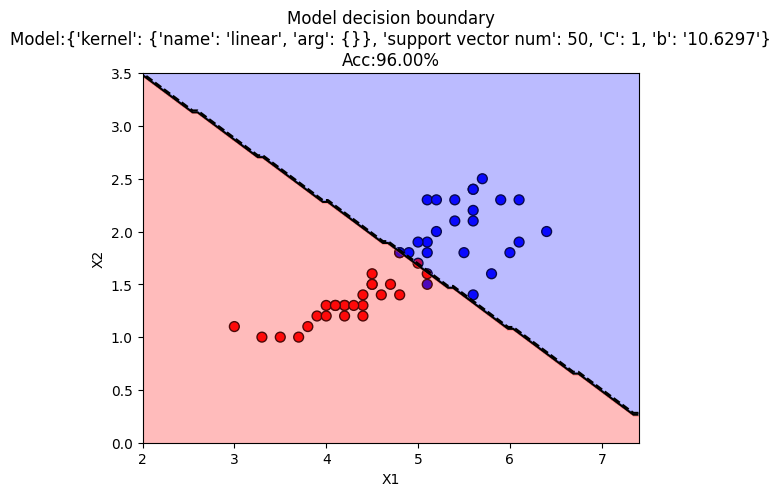

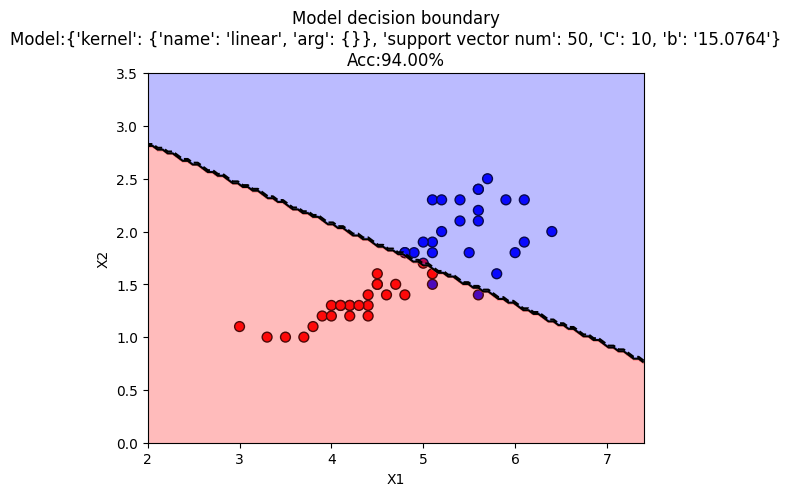

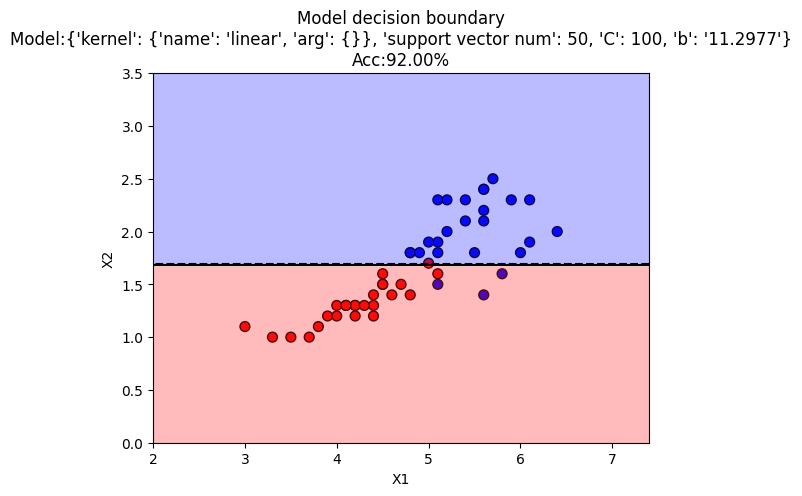

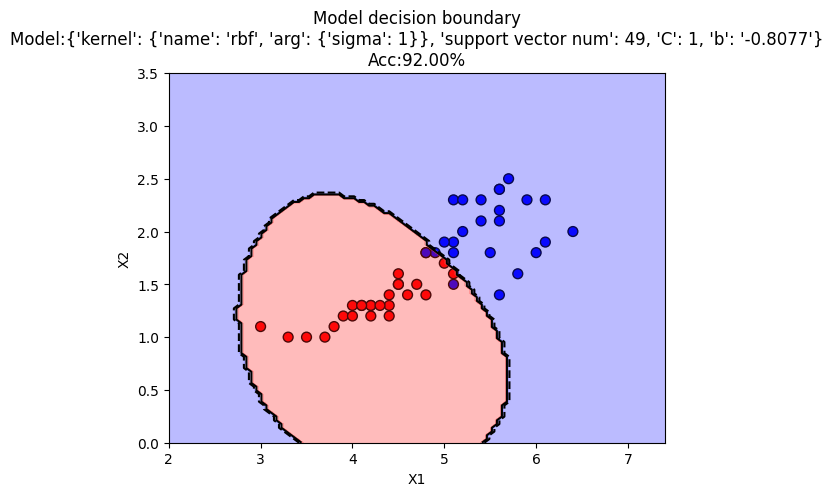

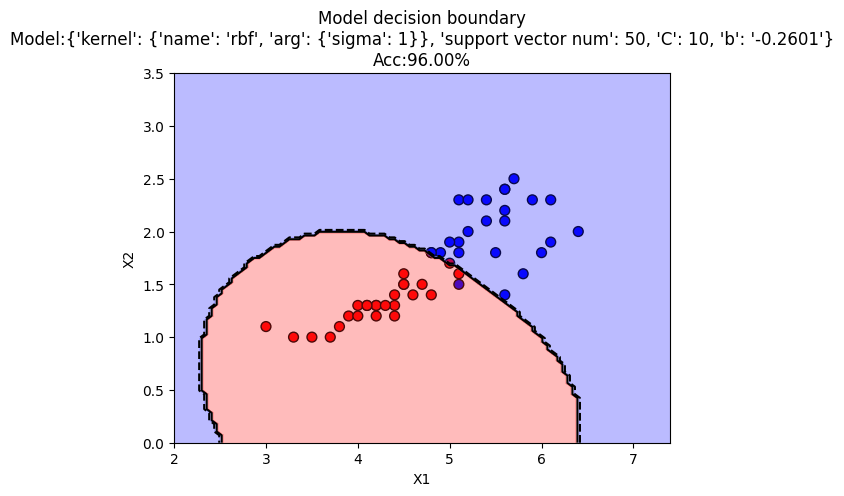

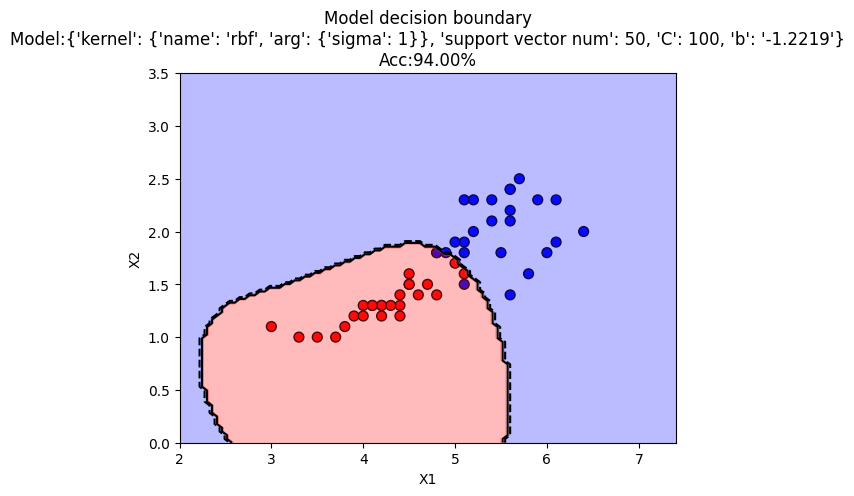

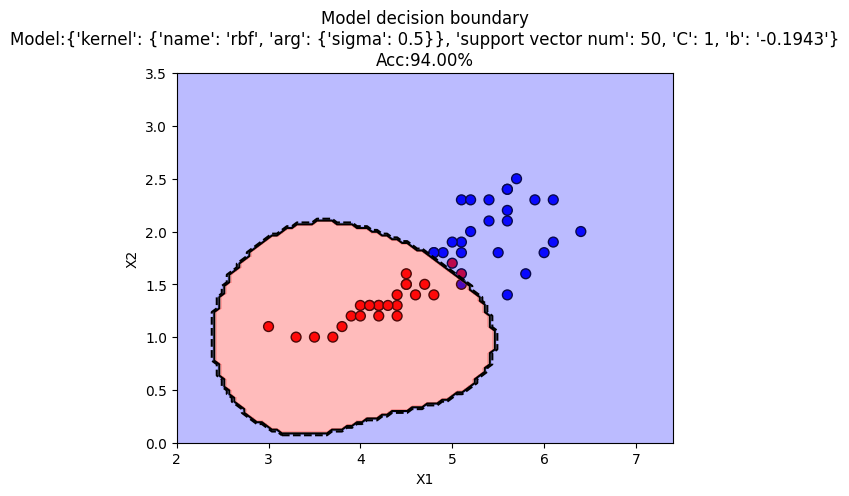

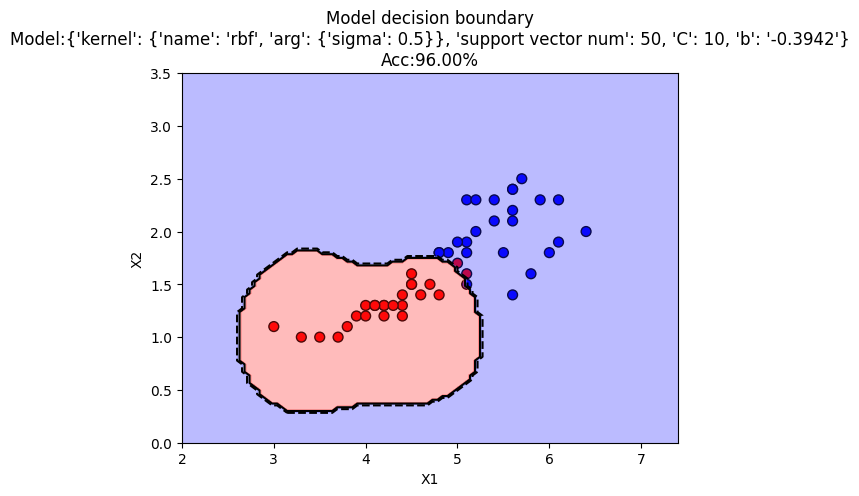

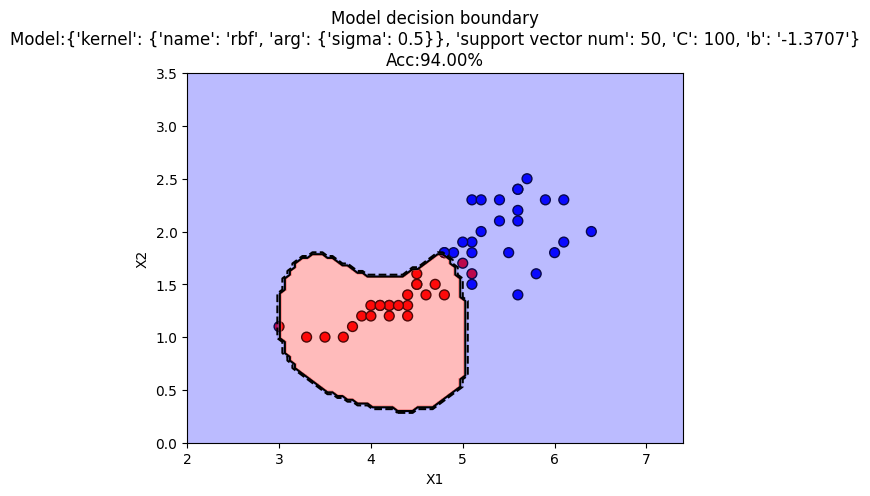

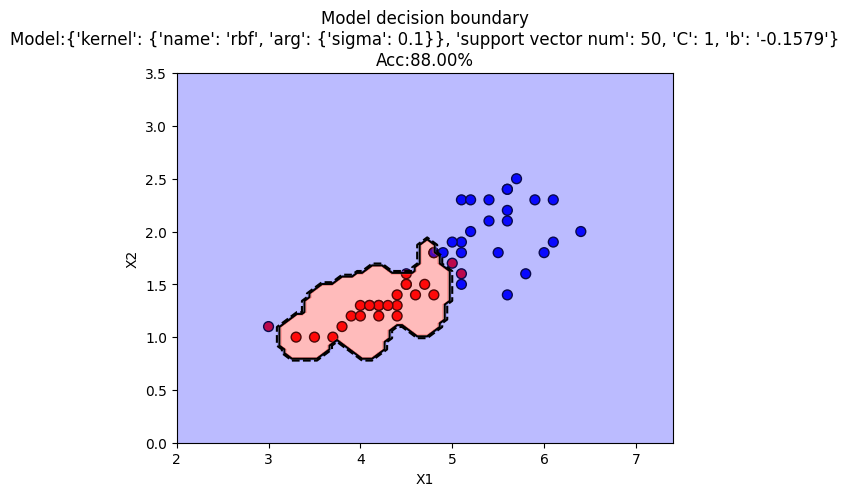

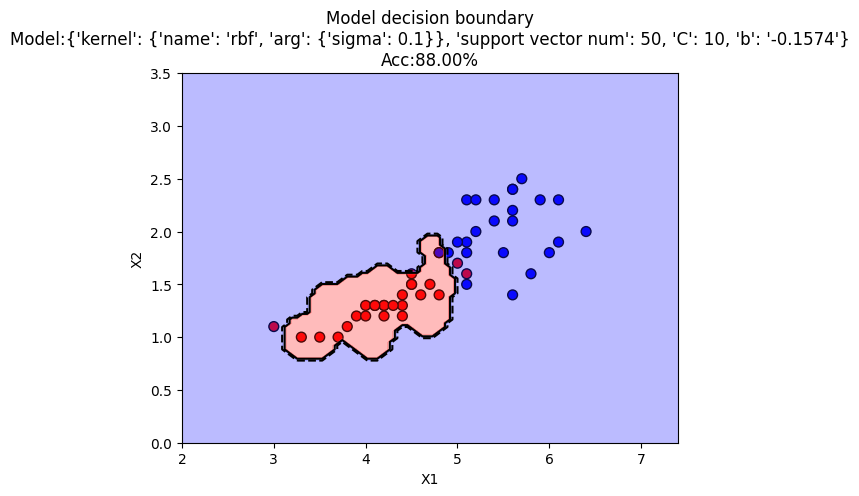

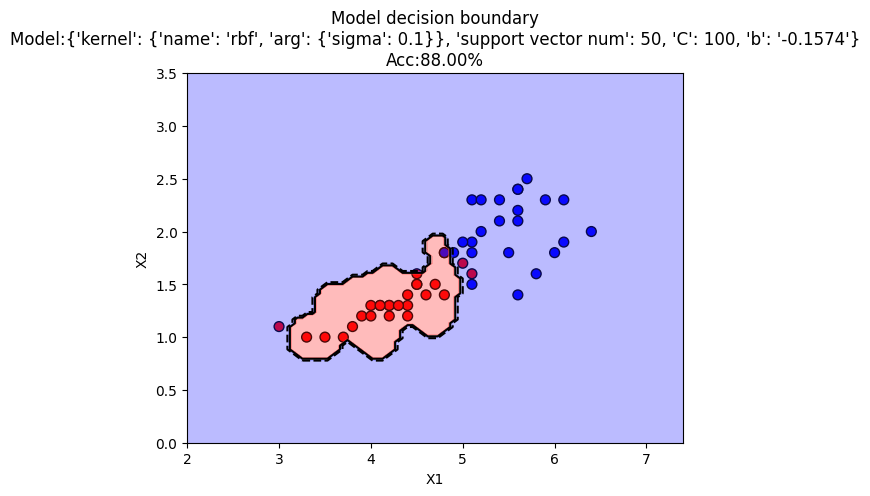

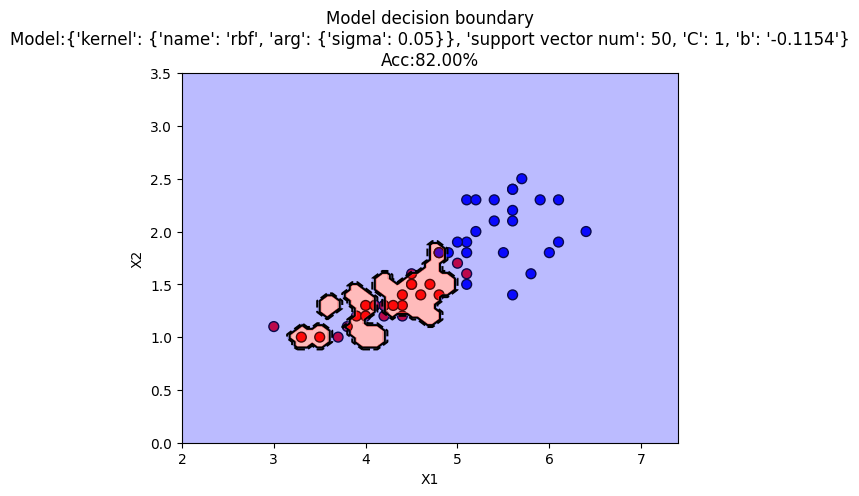

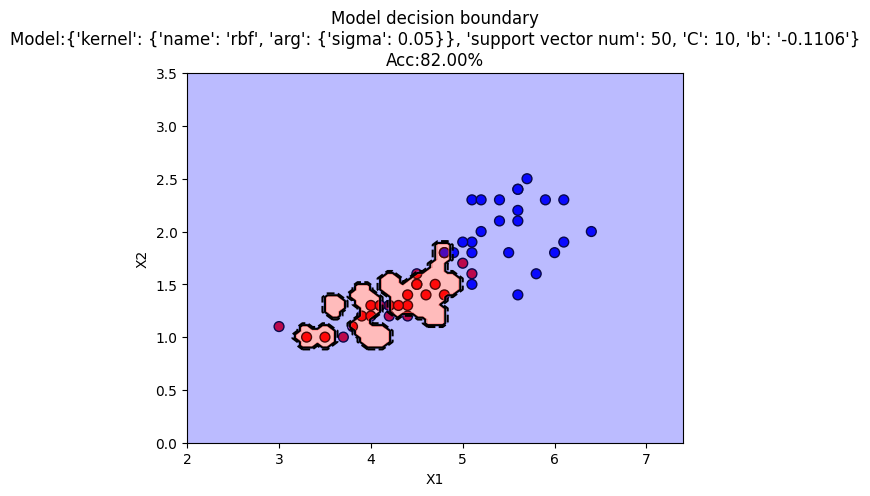

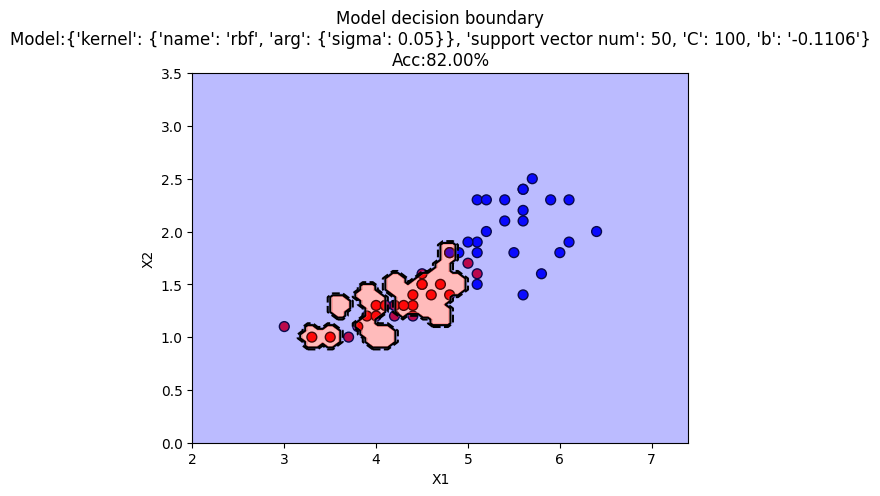

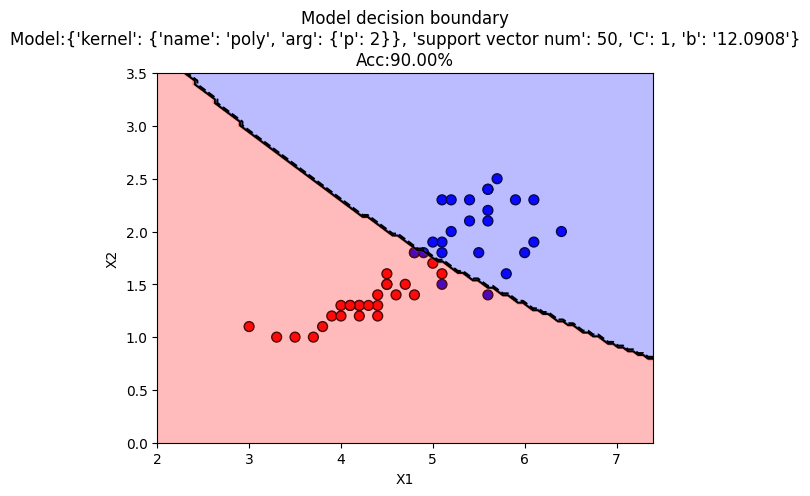

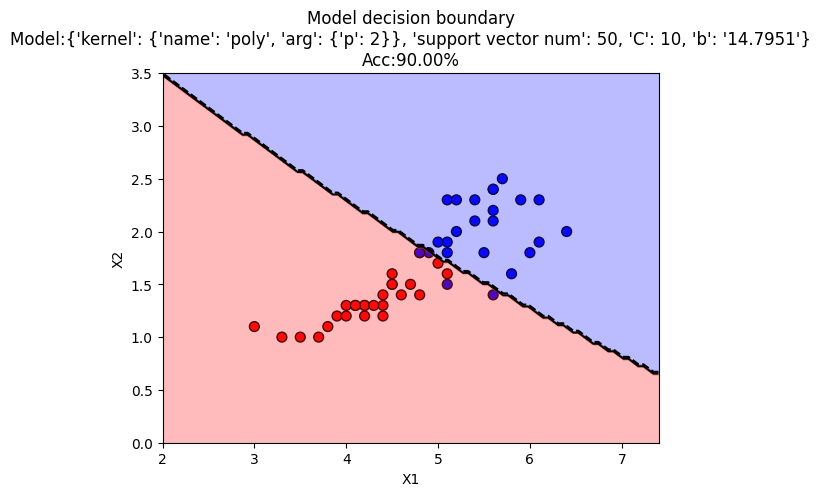

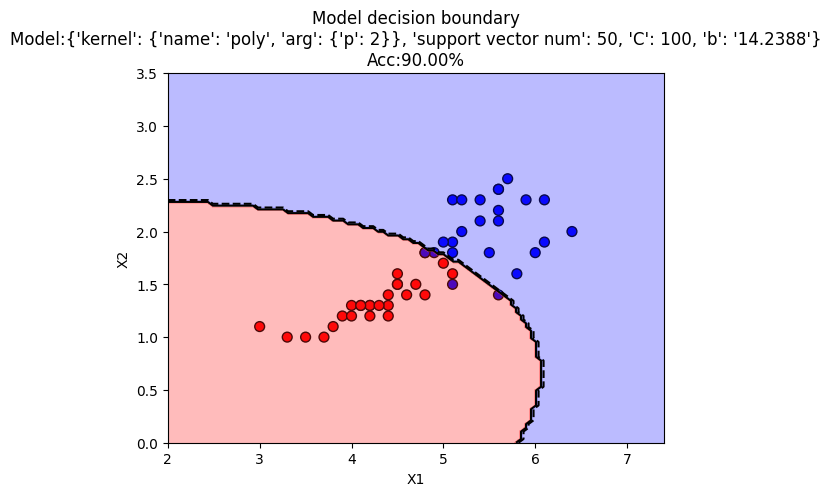

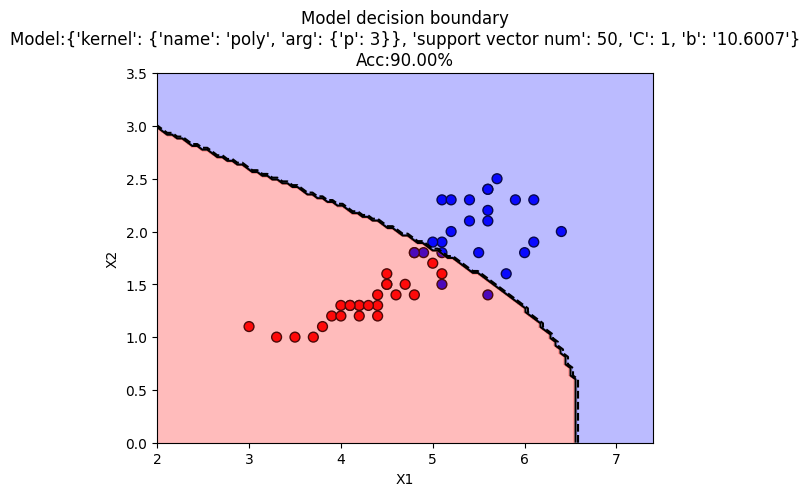

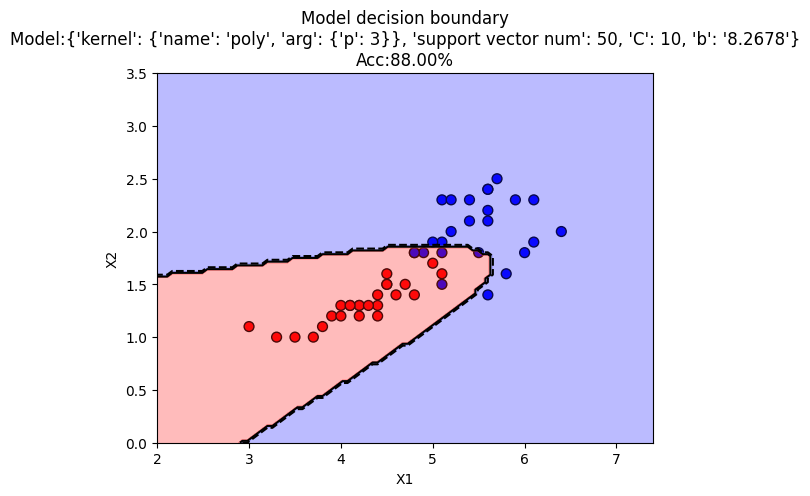

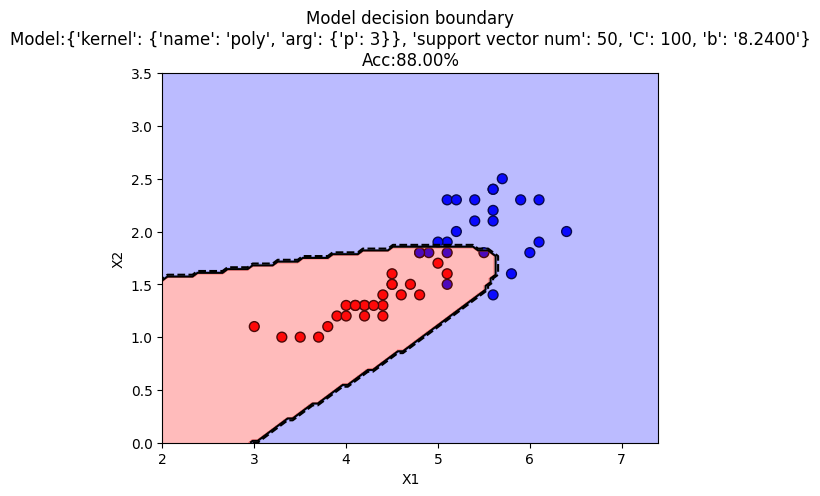

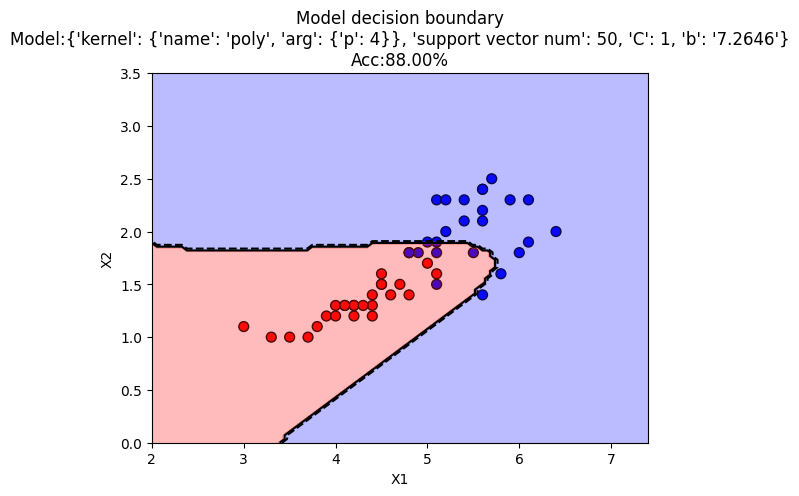

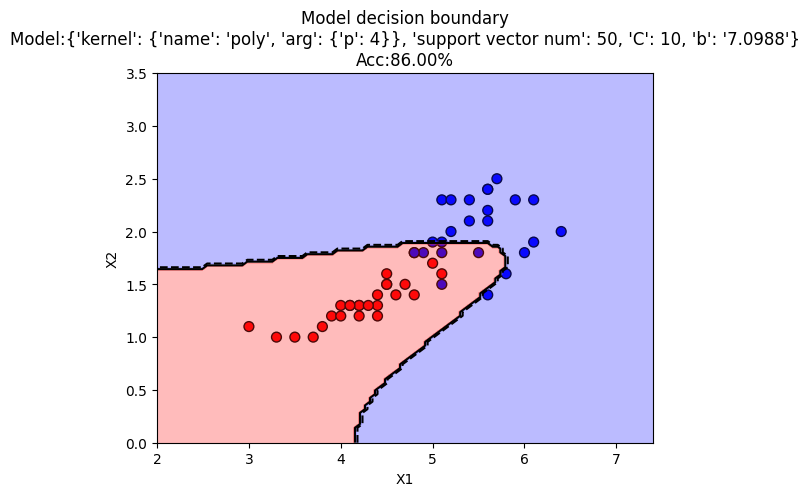

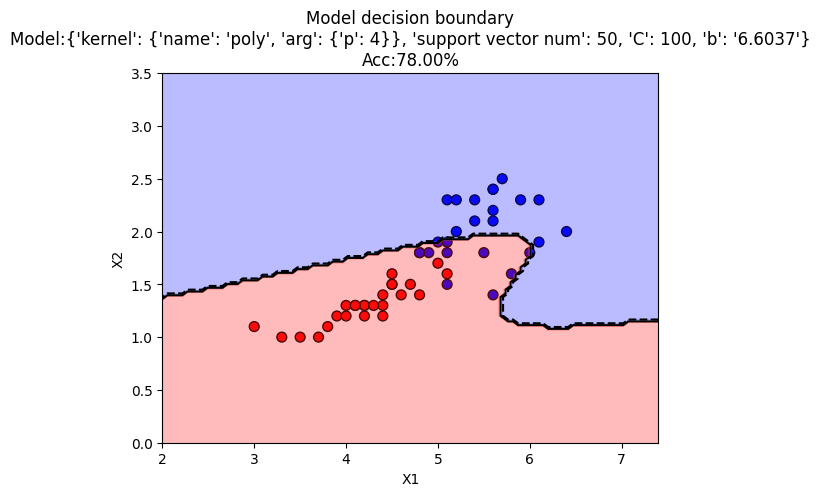

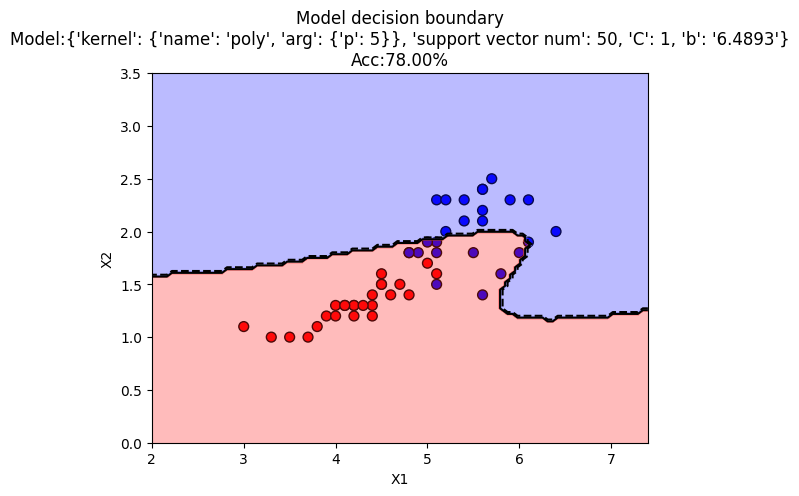

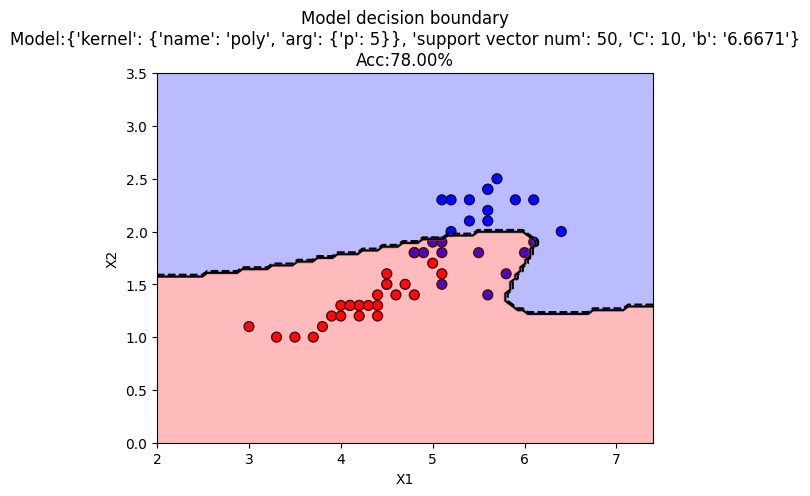

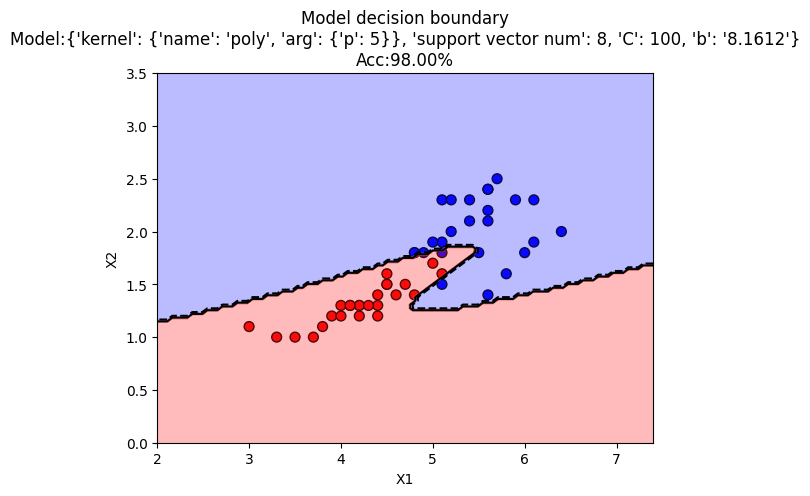

In [763]:
test_result = model_linear + model_rbf + model_poly
for test_result_item in test_result:
    test_result_item.plot_decision_boundary(assets_folder)